In [1]:
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
from matplotlib import pyplot
from pandas import datetime
from pandas import concat
import pandas as pd
import numpy as np

Using TensorFlow backend.


Transform the time series into a supervised learning problem
Transform the time series data so that it is stationary.
Transform the observations to have a specific scale.

In [2]:
from google.colab import files
files.upload()

Saving shampoo.csv to shampoo.csv


{'shampoo.csv': b'Month,Sales of shampoo over a three year period\r\n2019-01-01,266\r\n2019-01-02,145.9\r\n2019-01-03,183.1\r\n2019-01-04,119.3\r\n2019-01-05,180.3\r\n2019-01-06,168.5\r\n2019-01-07,231.8\r\n2019-01-08,224.5\r\n2019-01-09,192.8\r\n2019-01-10,122.9\r\n2019-01-11,336.5\r\n2019-01-12,185.9\r\n2019-02-01,194.3\r\n2019-02-02,149.5\r\n2019-02-03,210.1\r\n2019-02-04,273.3\r\n2019-02-05,191.4\r\n2019-02-06,287\r\n2019-02-07,226\r\n2019-02-08,303.6\r\n2019-02-09,289.9\r\n2019-02-10,421.6\r\n2019-02-11,264.5\r\n2019-02-12,342.3\r\n2019-03-01,339.7\r\n2019-03-02,440.4\r\n2019-03-03,315.9\r\n2019-03-04,439.3\r\n2019-03-05,401.3\r\n2019-03-06,437.4\r\n2019-03-07,575.5\r\n2019-03-08,407.6\r\n2019-03-09,682\r\n2019-03-10,475.3\r\n2019-03-11,581.3\r\n2019-03-12,646.9'}

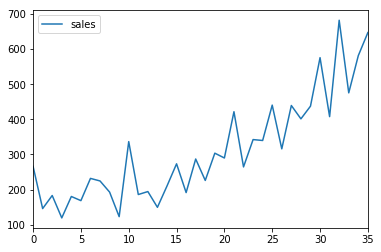

In [4]:
df = pd.read_csv('shampoo.csv')
df.drop(['Month'], axis=1,inplace=True)
df.columns = ['sales']
df.plot()
pyplot.show()

The trend can be removed from the observations, then added back to forecasts later to return the prediction to the original scale and calculate a comparable error score.

In [0]:
sale1= df[1:]
sale2 = df[:-1]
sale1.index = sale2.index
sale_diff=sale1-sale2

After detrending the sale we generate a supervised model

In [0]:
sale_diff1=sale_diff[1:]
sale_diff2 = sale_diff[:-1]
#concate the series
sale_diff2.index = sale_diff1.index
sale_diff_new=pd.concat([sale_diff2, sale_diff1],axis=1)

In [0]:
train, test = sale_diff_new[0:-12], sale_diff_new[-12:]

The default activation function for LSTMs is the hyperbolic tangent (tanh), which outputs values between -1 and 1. This is the preferred range for the time series data.
therfore,We can transform the dataset to the range [-1, 1] using the MinMaxScaler class. 

In [0]:
# fit scaler
scaler = MinMaxScaler(feature_range=(-1, 1))
scaler = scaler.fit(train)

In [0]:
# transform train
train_scaled= scaler.transform(train)
# transform test
test_scaled = scaler.transform(test)

In [0]:
X, y = train_scaled[:,0], train_scaled[:,1]
X = X.reshape(X.shape[0], 1, 1)

In [0]:
# fit an LSTM network to training data
batch_size= 1
neurons=4
X, y = train_scaled[:,0], train_scaled[:,1]
X = X.reshape(X.shape[0], 1, 1)
model = Sequential()
model.add(LSTM(neurons, batch_input_shape=(batch_size, X.shape[1], X.shape[2]), stateful=True))
model.add(Dense(1))

In [0]:
nb_epoch=30
model.compile(loss='mean_squared_error', optimizer='adam')
for i in range(nb_epoch):
        model.fit(X, y, epochs=1, batch_size=batch_size, verbose=0, shuffle=False)
        model.reset_states()

In [0]:
yhat = model.predict(X, batch_size=batch_size)#[:,0]

In [0]:
Predict_matrix=np.vstack((X[:,0,0],yhat[:,0])).transpose()

In [0]:
Predict_matrix_inv=scaler.inverse_transform(Predict_matrix)

In [0]:
Predict_matrix_inv

array([[-1.20100000e+02,  6.44071854e+01],
       [ 3.72000000e+01,  4.27833873e+01],
       [-6.38000000e+01,  6.71903880e+01],
       [ 6.10000000e+01,  3.21107476e+01],
       [-1.18000000e+01,  3.55383058e+01],
       [ 6.33000000e+01, -2.95803607e-02],
       [-7.30000000e+00,  5.37804978e+00],
       [-3.17000000e+01,  2.30744576e+01],
       [-6.99000000e+01,  5.56999241e+01],
       [ 2.13600000e+02, -4.34036397e+01],
       [-1.50600000e+02,  4.00083600e+01],
       [ 8.40000000e+00,  3.48729374e+01],
       [-4.48000000e+01,  5.37705170e+01],
       [ 6.06000000e+01,  1.95993570e+01],
       [ 6.32000000e+01, -1.52973263e+01],
       [-8.19000000e+01,  3.09179210e+01],
       [ 9.56000000e+01, -1.98210531e+01],
       [-6.10000000e+01,  1.68728892e+01],
       [ 7.76000000e+01, -2.43118467e+01],
       [-1.37000000e+01, -1.31445370e+01],
       [ 1.31700000e+02, -8.06885378e+01],
       [-1.57100000e+02,  1.13070164e+01]])

In [0]:
xhat_retransform=Predict_matrix_inv[:,0].cumsum()
yhat_retransform=Predict_matrix_inv[:,1].cumsum()

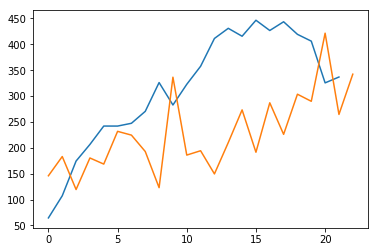

In [0]:
import matplotlib.pyplot as plt
plt.plot(yhat_retransform)
plt.plot(sale1[:23])
plt.show()